<a href="https://colab.research.google.com/github/terabitiya/election-fraud/blob/main/Fraud_Detection_Russia.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#pip install geopandas

In [ ]:
#pip install tueplots

In [3]:
%matplotlib inline
import numpy as np
import pylab as plt
import seaborn as sns
import pandas as pd
import geopandas
import tueplots
from mpl_toolkits.axes_grid1.axes_divider import make_axes_locatable

In [4]:
from tueplots import bundles
plt.rcParams.update(bundles.icml2022(family="sans-serif", usetex=False, column="full", nrows=2))
with plt.rc_context(bundles.icml2022(family="sans-serif", usetex=False, column="full", nrows=2)):
    pass

In [5]:
from google.colab import drive
drive.mount('/content/drive',force_remount=True)

Mounted at /content/drive


In [6]:
path = '/content/drive/MyDrive/Tuebingen/Data Literacy/Project/'
data_rus = pd.read_pickle(path+'data_rus.pkl')
parties_rus=['CPRF', 'LDPR', 'New_People','UR', 'Just', 'other']

In [7]:
voteshares_rus = data_rus.loc[:,parties_rus].apply(lambda x: x/data_rus['received']*100, axis=0)
voteshares_rus['region'] = data_rus['region']
voteshares_rus['turnout'] = data_rus['turnout']*100

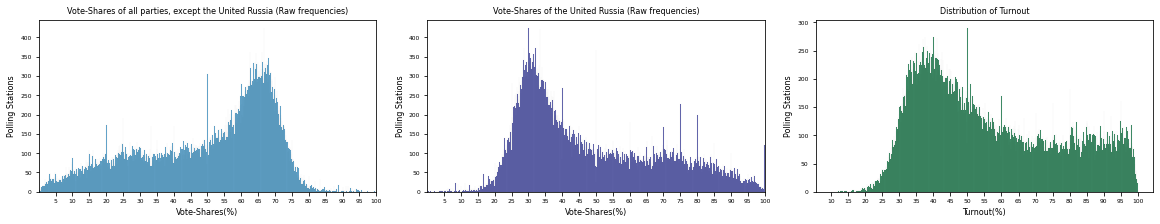

In [8]:
import matplotlib.ticker as plticker
loc = plticker.MultipleLocator(base=5.0) 

fig,axes = plt.subplots(1,3,figsize=(16,3))

sns.histplot(ax=axes[0],data=voteshares_rus.loc[:,['CPRF', 'LDPR', 'New_People', 'Just', 'other']].sum(axis=1), binwidth=.1, color='#3288bd')
axes[0].set_title('Vote-Shares of all parties, except the United Russia (Raw frequencies)')
axes[0].set(xlabel='Vote-Shares(%)',ylabel='Polling Stations')
axes[0].xaxis.set_major_locator(loc)
axes[0].set(xlim=(0,100))

sns.histplot(ax=axes[1],data=voteshares_rus['UR'], binwidth=.1, color='#313695') 
axes[1].set_title('Vote-Shares of the United Russia (Raw frequencies)')
axes[1].set(xlabel='Vote-Shares(%)',ylabel='Polling Stations')
axes[1].xaxis.set_major_locator(loc)
axes[1].set(xlim=(0,100))

sns.histplot(ax=axes[2],data=data_rus['turnout']*100, binwidth=.1, color = '#006837') 
axes[2].set_title('Distribution of Turnout')
axes[2].set(xlabel='Turnout(%)',ylabel='Polling Stations')
axes[2].xaxis.set_major_locator(loc)
plt.show()

In [9]:
def get_10bins(df):
    turnout_bins= pd.cut(df['turnout']*100, bins=np.arange(0,101,10), labels=False)
    df.loc[:,'turnout_bins']=turnout_bins
    df=df.groupby(by='turnout_bins').sum()
    perc_by_bins = pd.DataFrame(columns=['UR','received'])
    perc_by_bins['UR'] = df.UR/sum(df.UR)*100
    perc_by_bins['received'] = df.received/sum(df.received)*100
    perc_by_bins.index = ['(0-10]','(10-20]','(20,30]','(30,40]','(40,50]','(50,60]','(60,70]','(70,80]','(80,90]','(90,100]']
    return perc_by_bins

In [10]:
get_10bins(data_rus).T

,(0-10],(10-20],"(20,30]","(30,40]","(40,50]","(50,60]","(60,70]","(70,80]","(80,90]","(90,100]"
UR,0.000474,0.043903,2.107810,13.404772,14.514966,10.553866,10.019883,11.790049,17.011035,20.553242
received,0.000813,0.070217,3.508413,20.991142,19.871340,11.596458,8.714530,9.046689,11.527333,14.673065


## Vote-Shares in Regions

In [11]:
def prepare_shape():
    shape =geopandas.read_file('https://raw.githubusercontent.com/Kreozot/russian-geo-data/master/geo.json')
    shape = shape.iloc[:,[3,4,7,9]]
    reg_dict = {'Altay':'Алтайский край','Amur':'Амурская область',"Arkhangel'sk":'Архангельская область',"Astrakhan'":'Астраханская область','Belgorod':'Белгородская область',
    'Bryansk':'Брянская область','Vladimir':'Владимирская область','Volgograd':'Волгоградская область','Vologda':'Вологодская область','Voronezh':'Воронежская область',
    'Yevrey':'Еврейская автономная область','Zabaikalskiy Krai':'Забайкальский край','Ivanovo':'Ивановская область','Irkutsk':'Иркутская область',
    'Kabardin-Balkar':'Кабардино-Балкарская Республика','Kaliningrad':'Калининградская область','Kaluga':'Калужская область','Kamchatka':'Камчатский край','Karachay-Cherkess':'Карачаево-Черкесская Республика',
    'Kemerovo':'Кемеровская область - Кузбасс','Kirov':'Кировская область','Kostroma':'Костромская область','Krasnodar':'Краснодарский край','Krasnoyarsk':'Красноярский край','Kurgan':'Курганская область',
    'Kursk':'Курская область','Leningrad':'Ленинградская область','Lipetsk':'Липецкая область','Maga Buryatdan':'Магаданская область','Moskva':'Московская область','Murmansk':'Мурманская область',
    'Nenets':'Ненецкий автономный округ','Nizhegorod':'Нижегородская область','Novgorod':'Новгородская область','Novosibirsk':'Новосибирская область','Omsk':'Омская область',
    'Orenburg':'Оренбургская область','Orel':'Орловская область','Penza':'Пензенская область',"Perm'":'Пермский край',"Primor'ye":'Приморский край','Pskov':'Псковская область',
    'Adygey':'Республика Адыгея (Адыгея)','Gorno-Altay':'Республика Алтай','Bashkortostan':'Республика Башкортостан','Buryat':'Республика Бурятия','Dagestan':'Республика Дагестан',
    'Ingush':'Республика Ингушетия','Kalmyk':'Республика Калмыкия','Karelia':'Республика Карелия','Komi':'Республика Коми','Crimea':'Республика Крым','Mariy-El':'Республика Марий Эл',
    'Mordovia':'Республика Мордовия','Sakha':'Республика Саха (Якутия)','North Ossetia':'Республика Северная Осетия - Алания','Tatarstan':'Республика Татарстан (Татарстан)',
    'Tuva':'Республика Тыва','Khakass':'Республика Хакасия','Rostov':'Ростовская область',"Ryazan'":'Рязанская область','Samara':'Самарская область','Saratov':'Саратовская область',
    'Sakhalin':'Сахалинская область','Sverdlovsk':'Свердловская область','Smolensk':'Смоленская область',"Stavropol'":'Ставропольский край','Tambov':'Тамбовская область',
    "Tver'":'Тверская область','Tomsk':'Томская область','Tula':'Тульская область',"Tyumen'":'Тюменская область','Udmurt':'Удмуртская Республика',"Ul'yanovsk":'Ульяновская область',
    'Khabarovsk':'Хабаровский край','Khanty-Mansiy':'Ханты-Мансийский автономный округ - Югра','Chelyabinsk':'Челябинская область','Chechnya':'Чеченская Республика','Chuvash':'Чувашская Республика - Чувашия',
    'Chukot':'Чукотский автономный округ','Yamal-Nenets':'Ямало-Ненецкий автономный округ',"Yaroslavl'":'Ярославская область','Moscow City':'город Москва','City of St. Petersburg':'город Санкт-Петербург',
    "Sevastopol'":'город Севастополь'}
    shape['region_RUS'] = shape['NAME_1'].replace(reg_dict)
    return shape

shape = prepare_shape() 

In [12]:
def get_df(df, shape):
    df=pd.merge(shape,
             df.groupby(by='region').mean().reset_index(),
             left_on = 'region_RUS', right_on='region'
             )
    df = df.loc[shape['NAME_1']!='Chukot'] # Removing Chukotsky Avtonomny Okrug
    return df

def plot_map(df,shape,party,palette,title):
    df = get_df(df,shape)
    fig,ax = plt.subplots(figsize = (30, 30))
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="2%", pad=-10)
    cax.tick_params(labelsize=20)

    gdf = geopandas.GeoDataFrame(df, geometry="geometry")
    gdf.plot(column=party,legend=True,ax=ax,cax=cax,cmap=palette)
    ax.set_title(title, fontsize=15)

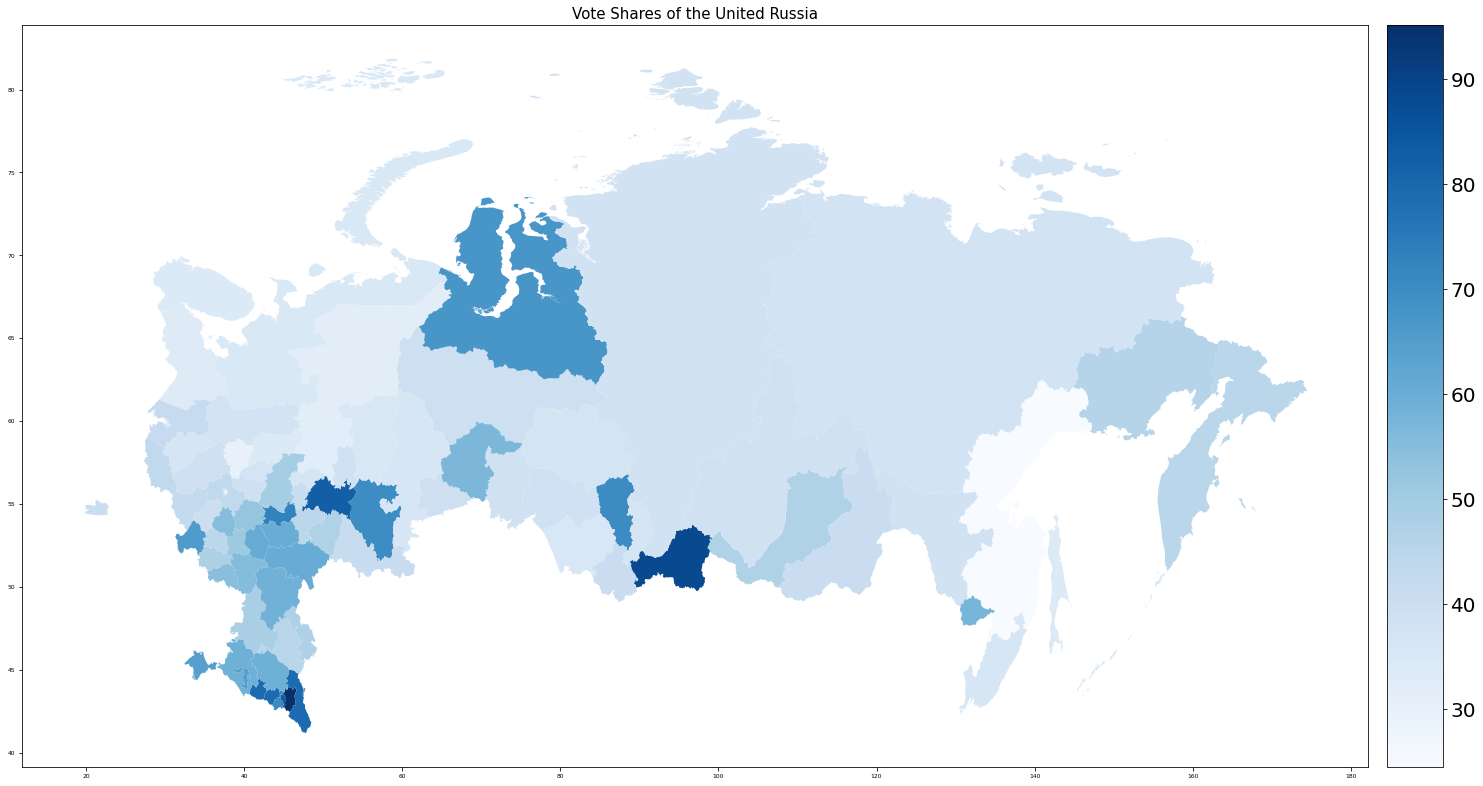

In [13]:
plot_map(voteshares_rus,shape,'UR','Blues','Vote Shares of the United Russia')

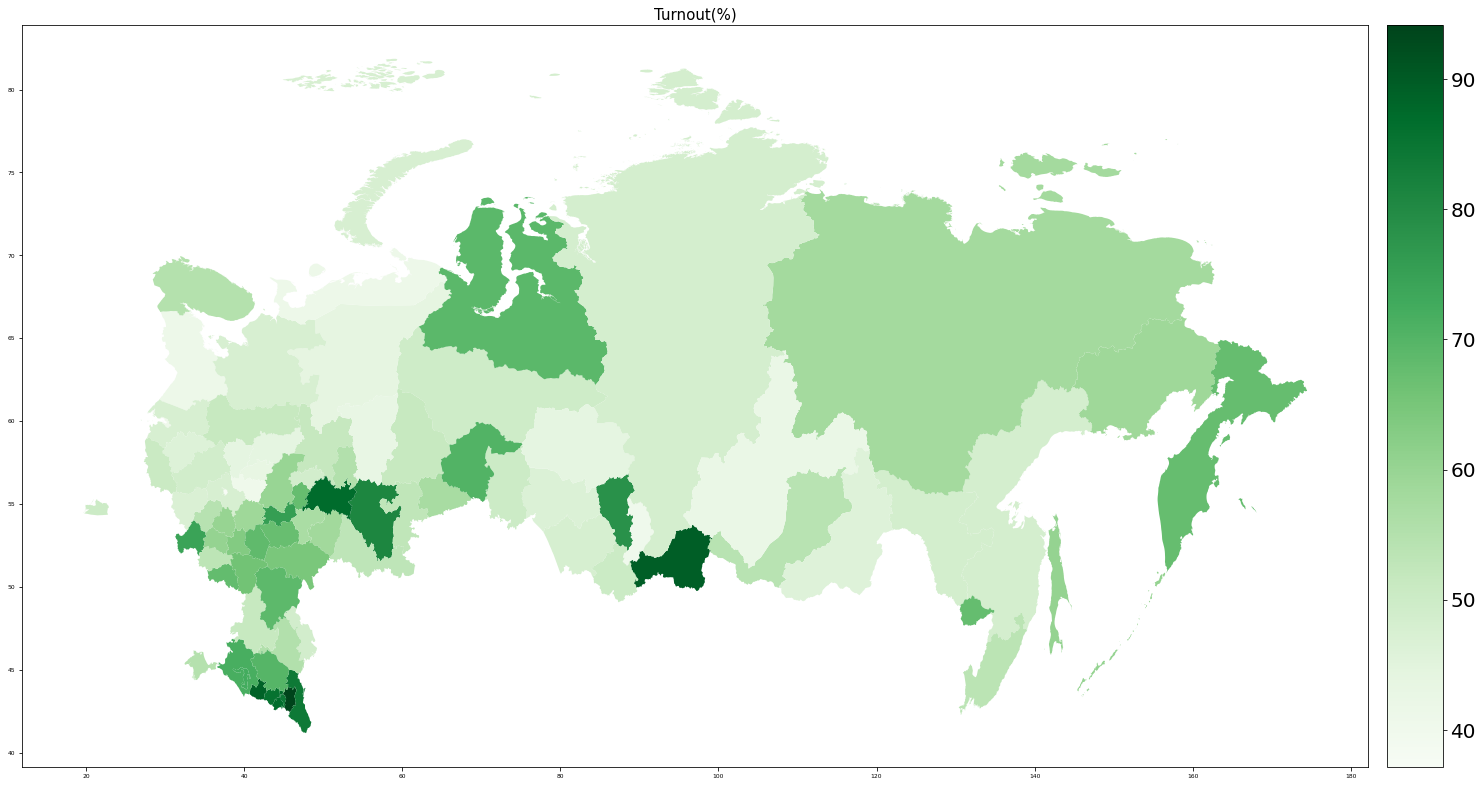

In [14]:
plot_map(voteshares_rus,shape,'turnout','Greens','Turnout(%)')

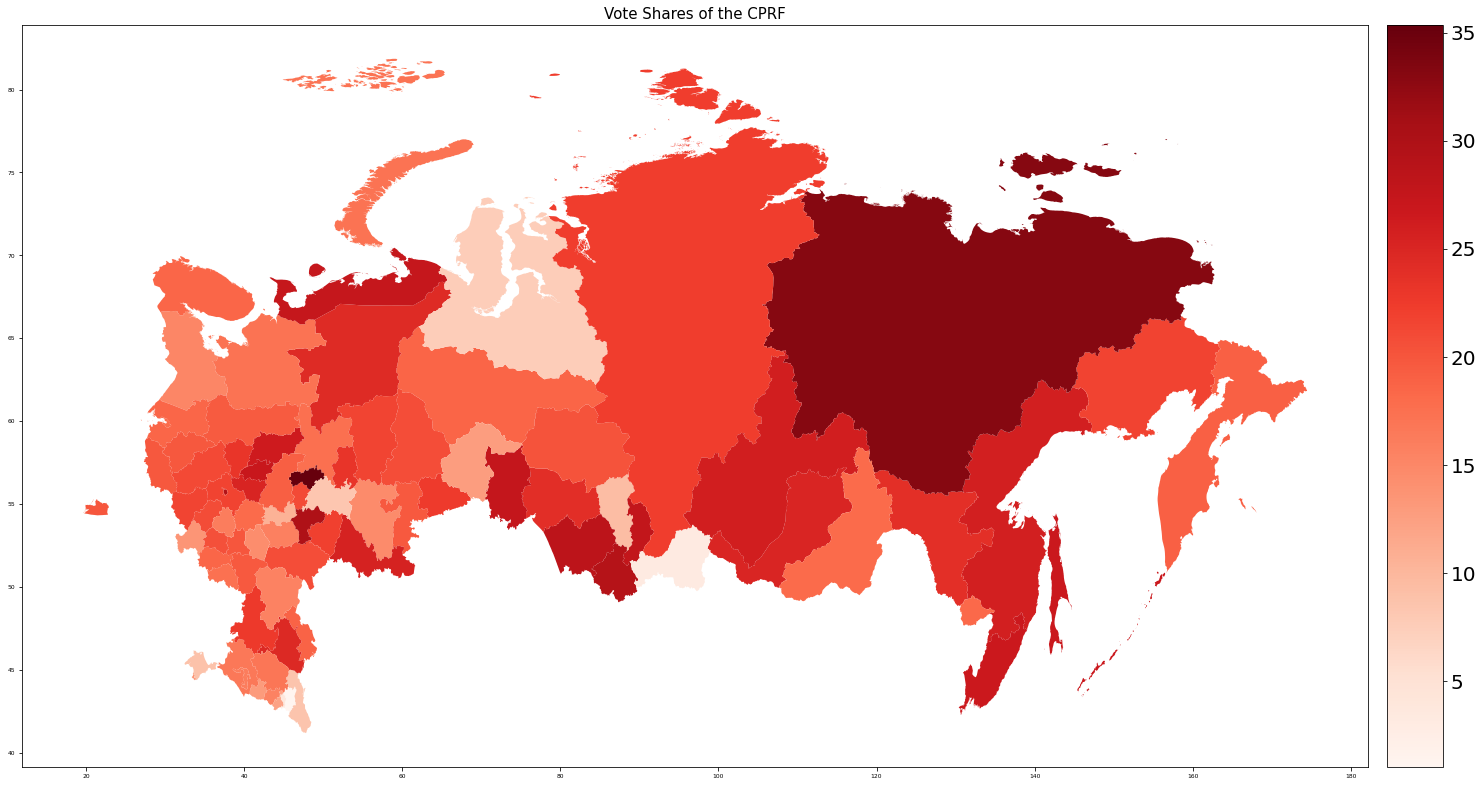

In [15]:
plot_map(voteshares_rus,shape,'CPRF','Reds','Vote Shares of the CPRF')

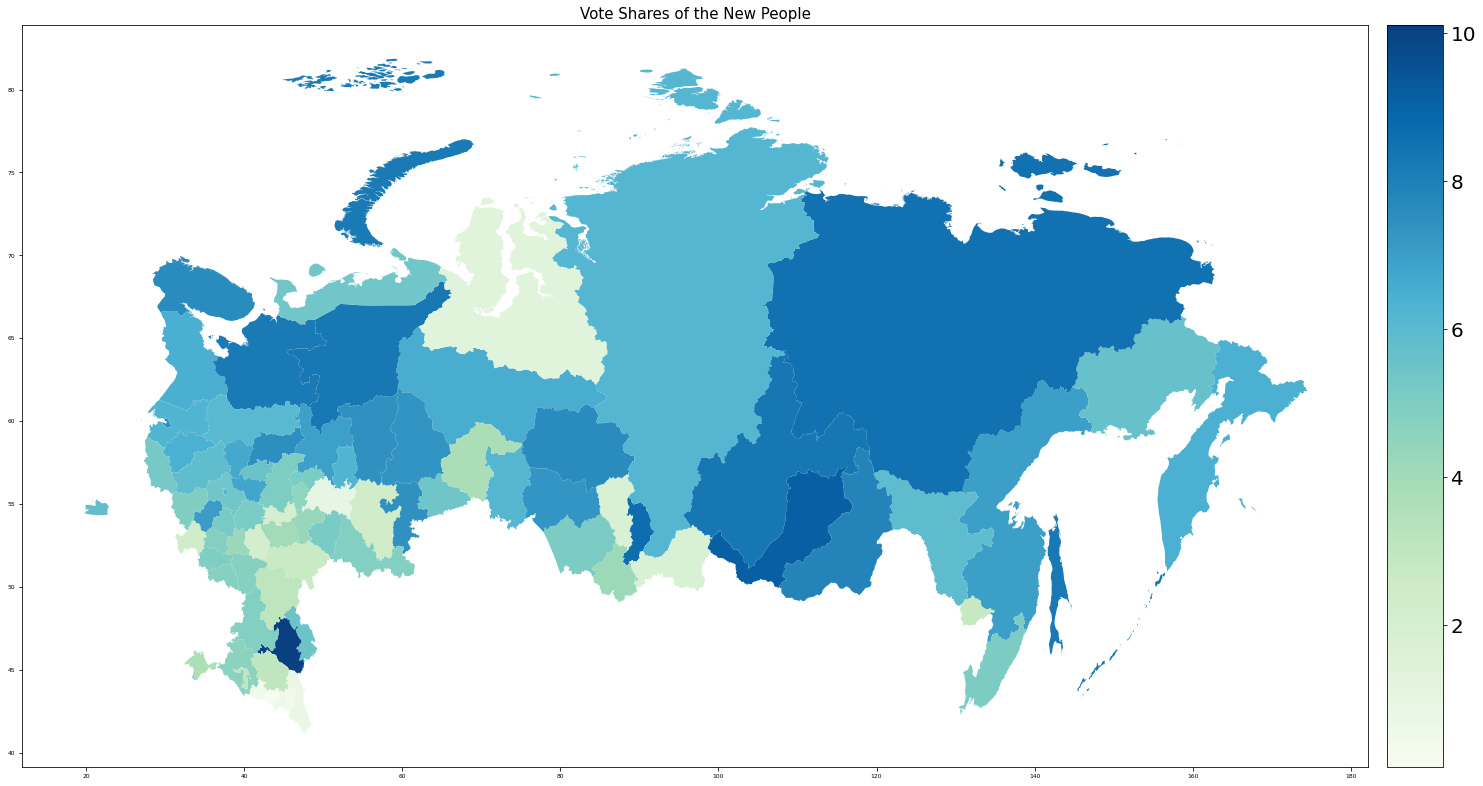

In [16]:
plot_map(voteshares_rus,shape,'New_People','GnBu','Vote Shares of the New People')

## Anomalous Integer peaks detection

Fraud detection is based on Dmitry Kobak, Sergey Shpilkin, Maxim S. Pshenichnikov, "Integer percentages as electoral falsification fingerprints",Ann. Appl. Stat. 10(1): 54-73 (March 2016). DOI: 10.1214/16-AOAS904

And https://github.com/dkobak/elections/blob/master/analysis/duma2021/duma2021.ipynb

In [17]:
def simulation(data_reg,party_name,binwidth=0.1,prctl=99.9,nsim=1000,seed=21):
    df_sim = pd.DataFrame(columns=['region','anomaly_all','anomaly_share','anomaly_turnout','std_all','std_share','std_turnout','quantile_all','quantile_share','quantile_turnout'])
    i=0
    for name,region in data_reg.groupby(by='region'):
        voters = region['voters'].values
        party = region[party_name].values
        received = region['received'].values
        given = region['given'].values

        p_party = 100 * party/received
        p_turnout = 100 * given/voters

        integer = np.zeros((3,1)) 
        v = np.ones_like(voters)
        integer[0,0] = np.sum(v[(np.abs(p_party - np.round(p_party))  <= binwidth/2) | 
                          (np.abs(p_turnout - np.round(p_turnout))  <= binwidth/2)])
        integer[1,0] = np.sum(v*(np.abs(p_party - np.round(p_party))  <= binwidth/2))
        integer[2,0] = np.sum(v*(np.abs(p_turnout - np.round(p_turnout))  <= binwidth/2))


        party_binom = np.zeros((nsim, len(voters)))
        turnout_binom  = np.zeros((nsim, len(voters)))
        np.random.seed(seed)
        # n is a polling station
        for n in range(len(voters)):
            party_binom[:,n] = np.random.binomial(n=received[n], 
                                               p=party[n]/received[n], 
                                               size=nsim)
            turnout_binom[:,n]  = np.random.binomial(n=voters[n],   
                                               p=given[n] /voters[n],   
                                               size=nsim)
   
        p_party = 100 * party_binom/received
        p_turnout = 100 * turnout_binom/voters  

        integer_mc = np.zeros((3,1,nsim)) 
        integer_mc[0,0,:] = np.sum(v * ((np.abs(p_party - np.round(p_party)) <= binwidth/2) | 
                                            (np.abs(p_turnout - np.round(p_turnout)) <= binwidth/2)),axis=1)
        integer_mc[1,0,:] = np.sum(v * (np.abs(p_party - np.round(p_party)) <= binwidth/2),axis=1)
        integer_mc[2,0,:] = np.sum(v * (np.abs(p_turnout - np.round(p_turnout)) <= binwidth/2),axis=1)

        d = integer - np.mean(integer_mc, axis=2) 
        s = np.std(integer_mc, axis=2) 
        q = np.percentile(integer_mc, prctl, axis=2) - np.mean(integer_mc, axis=2)   
        df_sim.loc[i] = [name,d[0][0],d[1][0],d[2][0],s[0][0],s[1][0],s[2][0],q[0][0],q[1][0],q[2][0]]
        i+=1
 
    return df_sim

In [18]:
filt = (data_rus['voters'] >= 100) & (data_rus['voters']<10000)
data_reg=data_rus.loc[filt]

In [19]:
df_sim_UR = simulation(data_reg,'UR')

In [20]:
df_sim_UR.loc[df_sim_UR.anomaly_share>df_sim_UR.quantile_share]#123 gives a little bit different result

,region,anomaly_all,anomaly_share,anomaly_turnout,std_all,std_share,std_turnout,quantile_all,quantile_share,quantile_turnout
5,Брянская область,53.790,44.766,19.770,12.379657,9.530438,9.868997,34.799,28.770,28.772
7,Волгоградская область,72.042,68.029,24.514,14.843862,11.224088,11.799907,40.046,30.042,31.520
22,Краснодарский край,179.605,106.169,128.676,20.151451,15.367382,15.401786,57.612,41.171,48.688
44,Республика Башкортостан,239.573,96.421,185.525,21.091057,16.525851,16.573635,73.575,62.424,52.525
46,Республика Дагестан,87.847,62.752,41.680,16.589322,12.032643,12.620602,50.852,32.760,37.685
56,Республика Татарстан (Татарстан),170.876,80.054,148.537,20.004965,15.329941,15.950192,54.892,41.056,49.538
61,Самарская область,50.969,42.577,9.328,16.208147,12.271270,12.689067,46.974,31.580,39.330
66,Ставропольский край,110.314,55.440,82.976,13.772487,10.728672,10.410352,45.326,27.446,33.983


In [21]:
df_sim_CPRF = simulation(data_reg,'CPRF')

In [22]:
df_sim_CPRF.loc[df_sim_CPRF.anomaly_share>df_sim_CPRF.quantile_share]

,region,anomaly_all,anomaly_share,anomaly_turnout,std_all,std_share,std_turnout,quantile_all,quantile_share,quantile_turnout
7,Волгоградская область,67.467,59.447,24.335,14.928862,10.964086,11.606842,36.487,34.453,37.335
9,Воронежская область,32.280,41.707,-5.521,15.575224,11.556260,12.192931,48.283,32.712,40.482
22,Краснодарский край,190.408,95.494,126.957,20.877441,16.072211,15.433637,61.410,52.496,45.959
44,Республика Башкортостан,206.727,61.189,185.888,21.920732,16.394123,17.018092,64.728,50.189,43.891
56,Республика Татарстан (Татарстан),181.851,77.251,147.758,19.654435,15.389282,15.173643,57.870,47.252,49.760
66,Ставропольский край,119.772,57.246,82.619,13.862324,10.944199,10.248309,38.773,36.258,29.619


In [23]:
df_sim_NP = simulation(data_reg,'New_People')

In [24]:
df_sim_NP.loc[df_sim_NP.anomaly_share>df_sim_NP.quantile_share]

,region,anomaly_all,anomaly_share,anomaly_turnout,std_all,std_share,std_turnout,quantile_all,quantile_share,quantile_turnout
22,Краснодарский край,158.901,59.52,127.797,20.617934,15.766978,15.968588,60.903,45.528,60.805


In [25]:
def get_bins(df):
    turnout_bins= pd.cut(df['turnout']*100, bins=np.arange(0,101,1), labels=False)
    df.loc[:,'turnout_bins']=turnout_bins
    df=df.groupby(by='turnout_bins').sum()
    return df

def plot_shpilkin(dfs,parties,countries=None,cum=False):
    fig,axes = plt.subplots(1,2,figsize=(8,4))
    for i in [0,1]:
        df = get_bins(dfs[i])
        for party in parties[i]:
            if cum:
                axes[i].plot(df.index,df[party].cumsum(),label=party)
            else: axes[i].plot(df.index,df[party],label=party)
            axes[i].set_title(countries[i])
            axes[i].set(xlabel='Turnout (%)',ylabel='Number of Votes in the Interval of 1% Turnout')
        axes[i].legend()
    plt.suptitle("Votes Distribution Depending on Turnout")
    plt.savefig(path+"Vote_Distr_VS_Turnout_"+countries[0]+".pdf", format="pdf")
    plt.show()

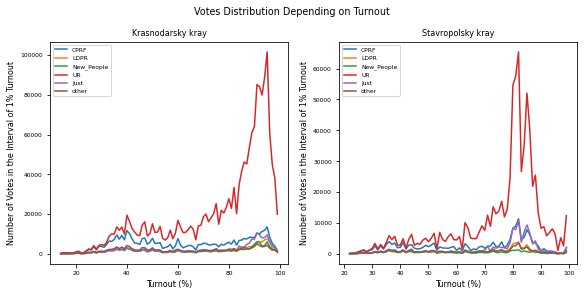

In [26]:
import warnings
warnings.filterwarnings("ignore")

reg1=data_reg.loc[data_reg['region']=='Краснодарский край']
reg2=data_reg.loc[data_reg['region']=='Ставропольский край']
plot_shpilkin([reg1, reg2],
              [parties_rus,parties_rus],
             ['Krasnodarsky kray','Stavropolsky kray']
              )

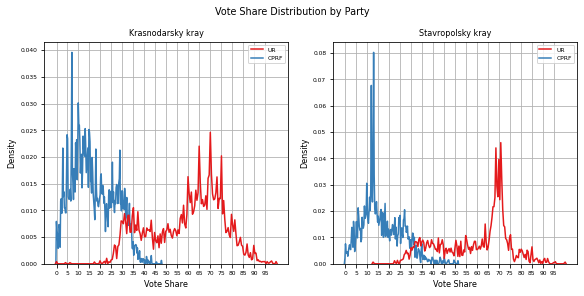

In [27]:
fig,axes = plt.subplots(1,2,figsize=(8,4))

ax1=sns.kdeplot(ax=axes[0],data=voteshares_rus.loc[voteshares_rus['region']=='Краснодарский край',['UR','CPRF']], palette='Set1',linewidth=1.5, bw_adjust=0.05)
ax1.set(xlabel='Vote Share')
ax1.set_title('Krasnodarsky kray')
ax1.set_xticks(np.arange(0,100,5))
ax1.grid(True)

ax2=sns.kdeplot(ax=axes[1],data=voteshares_rus.loc[voteshares_rus['region']=='Ставропольский край',['UR','CPRF']], palette='Set1',linewidth=1.5, bw_adjust=0.05)
ax2.set(xlabel='Vote Share')
ax2.set_title('Stavropolsky kray')
ax2.set_xticks(np.arange(0,100,5))
ax2.grid(True)

fig.suptitle('Vote Share Distribution by Party')
plt.savefig(path+"Vote_Distr_Krasnodar_Stavropol.pdf", format="pdf")
plt.show()

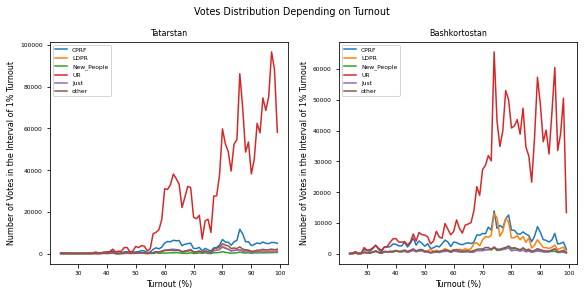

In [28]:
reg1=data_reg.loc[data_reg['region']=='Республика Татарстан (Татарстан)']
reg2=data_reg.loc[data_reg['region']=='Республика Башкортостан']
plot_shpilkin([reg1, reg2],
              [parties_rus,parties_rus],
             ['Tatarstan','Bashkortostan']
              )

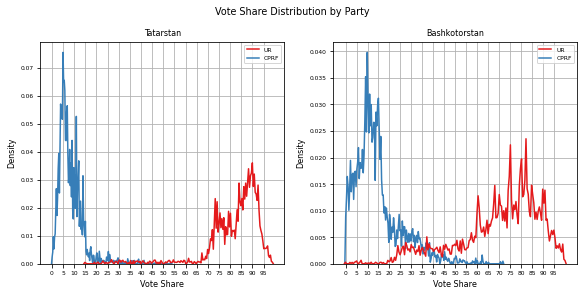

In [29]:
fig,axes = plt.subplots(1,2,figsize=(8,4))

ax1=sns.kdeplot(ax=axes[0],data=voteshares_rus.loc[voteshares_rus['region']=='Республика Татарстан (Татарстан)',['UR','CPRF']], palette='Set1',linewidth=1.5, bw_adjust=0.05)
ax1.set(xlabel='Vote Share')
ax1.set_title('Tatarstan')
ax1.set_xticks(np.arange(0,100,5))
ax1.grid(True)

ax2=sns.kdeplot(ax=axes[1],data=voteshares_rus.loc[voteshares_rus['region']=='Республика Башкортостан',['UR','CPRF']], palette='Set1',linewidth=1.5, bw_adjust=0.05)
ax2.set(xlabel='Vote Share')
ax2.set_title('Bashkotorstan')
ax2.set_xticks(np.arange(0,100,5))
ax2.grid(True)

fig.suptitle('Vote Share Distribution by Party')
plt.savefig(path+"Vote_Distr_Tatarstan_Bashkortostan.pdf", format="pdf")
plt.show()

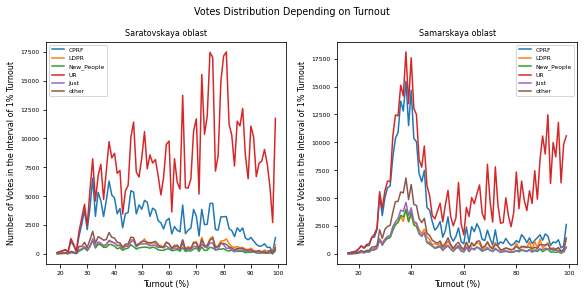

In [30]:
reg1=data_reg.loc[data_reg['region']=='Саратовская область']
reg2=data_reg.loc[data_reg['region']=='Самарская область']
plot_shpilkin([reg1, reg2],
              [parties_rus,parties_rus],
             ['Saratovskaya oblast','Samarskaya oblast']
              )

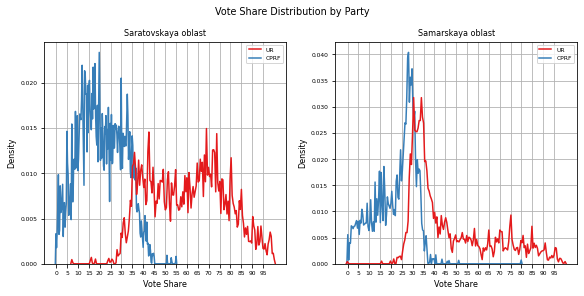

In [31]:
fig,axes = plt.subplots(1,2,figsize=(8,4))

ax1=sns.kdeplot(ax=axes[0],data=voteshares_rus.loc[voteshares_rus['region']=='Саратовская область',['UR','CPRF']], palette='Set1',linewidth=1.5, bw_adjust=0.05)
ax1.set(xlabel='Vote Share')
ax1.set_title('Saratovskaya oblast')
ax1.set_xticks(np.arange(0,100,5))
ax1.grid(True)
ax2=sns.kdeplot(ax=axes[1],data=voteshares_rus.loc[voteshares_rus['region']=='Самарская область',['UR','CPRF']], palette='Set1',linewidth=1.5, bw_adjust=0.05)
ax2.set(xlabel='Vote Share')
ax2.set_title('Samarskaya oblast')
ax2.set_xticks(np.arange(0,100,5))
ax2.grid(True)
fig.suptitle('Vote Share Distribution by Party')
plt.savefig(path+"Vote_Distr_Saratov_Samara.pdf", format="pdf")
plt.show()

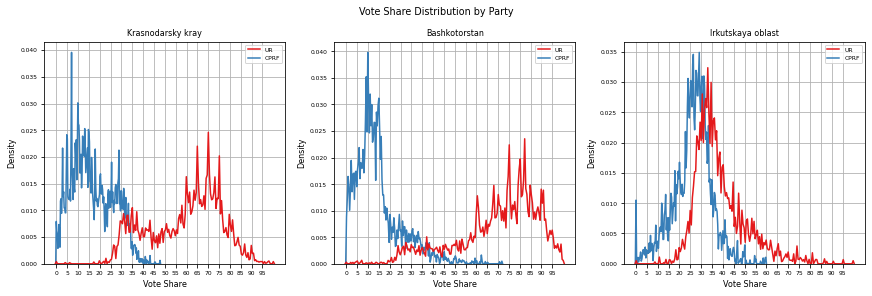

In [40]:
fig,axes = plt.subplots(1,3,figsize=(12,4))

ax1=sns.kdeplot(ax=axes[0],data=voteshares_rus.loc[voteshares_rus['region']=='Краснодарский край',['UR','CPRF']], palette='Set1',linewidth=1.5, bw_adjust=0.05)
ax1.set(xlabel='Vote Share')
ax1.set_title('Krasnodarsky kray')
ax1.set_xticks(np.arange(0,100,5))
ax1.grid(True)

ax2=sns.kdeplot(ax=axes[1],data=voteshares_rus.loc[voteshares_rus['region']=='Республика Башкортостан',['UR','CPRF']], palette='Set1',linewidth=1.5, bw_adjust=0.05)
ax2.set(xlabel='Vote Share')
ax2.set_title('Bashkotorstan')
ax2.set_xticks(np.arange(0,100,5))
ax2.grid(True)

ax3=sns.kdeplot(ax=axes[2],data=voteshares_rus.loc[voteshares_rus['region']=='Иркутская область',['UR','CPRF']], palette='Set1',linewidth=1.5, bw_adjust=0.05)
ax3.set(xlabel='Vote Share')
ax3.set_title('Irkutskaya oblast')
ax3.set_xticks(np.arange(0,100,5))
ax3.grid(True)

fig.suptitle('Vote Share Distribution by Party')
plt.savefig(path+"Vote_Distr_Krasnodar_Bashkortostan.pdf", format="pdf")
plt.show()